# SG with BN layer over the image model, language model and both

In this notebook we test SG's performances while using Batch Normalization over different domains  with LSTM of sizes 50, 100 and 150.

In [1]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
sys.path.append('../models/')
import retriever
from stats import stats
from tabulate import tabulate
from runSG import RunModel as Model

%matplotlib inline  

In [1]:
trainset_file = '../data/training/train_data.bin'
testset_file = '../data/training/test_data.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/SGBN/'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n-1 items where each item is [bounding box vector, bounding box spatial features]. Note that different entries  might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the true bbox </li>
</ul>

In [3]:
trainset = np.load(open(trainset_file, 'rb'))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])

testset = np.load(open(testset_file, 'rb'))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

Number of words: 8242


## Txt BN

Adding Batch Normalization layer over only the language model (the last RNN output).

In [6]:
txtBN_tst, txtBN_trn = [], []
num_hiddens=[50, 100, 150]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'txtBN_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=testset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        bnorm=True,
        Urnn_norm=True, 
        Uatt_norm=False,
        params_dir=params_dir
    )

    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)

    tst, trn = m.train(trainset, testset, epochs_num=100)
    txtBN_tst.append(tst)
    txtBN_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

Hidden state size: 50
Train accuracy:1.000
Test accuracy:0.709
Train P@1:1.000
Test P@1:0.800
Train loss:0.002
Test loss:1.668


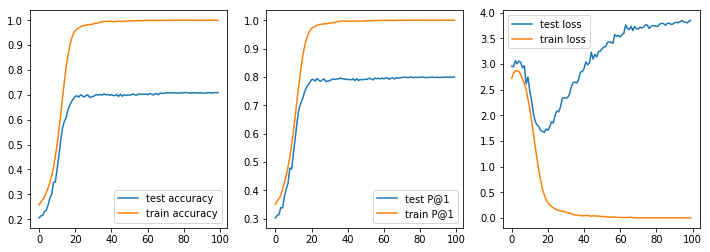

---------------------------------------------------------------------------------------------------- 

Hidden state size: 100
Train accuracy:1.000
Test accuracy:0.712
Train P@1:1.000
Test P@1:0.803
Train loss:0.002
Test loss:1.897


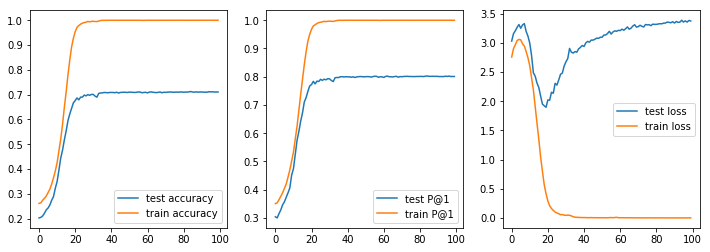

---------------------------------------------------------------------------------------------------- 

Hidden state size: 150
Train accuracy:1.000
Test accuracy:0.713
Train P@1:1.000
Test P@1:0.803
Train loss:0.002
Test loss:2.040


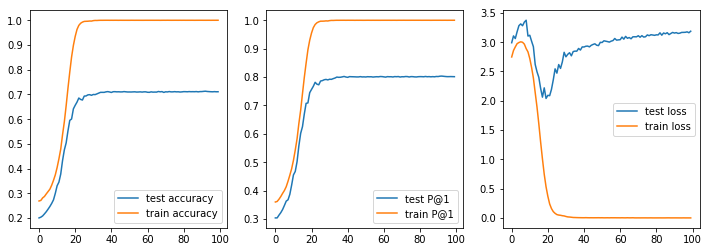

---------------------------------------------------------------------------------------------------- 



In [4]:
f = stats(txtBN_tst, txtBN_trn, epochs=100, params=[50, 100, 150])

In [5]:
arr = []
for i, num_hidden in enumerate([50, 100, 150]):
    arr.append([num_hidden,
               max(np.array(txtBN_tst[i])[:,0]), 
               max(np.array(txtBN_trn[i])[:,0]), 
               max(np.array(txtBN_tst[i])[:,1]), 
               max(np.array(txtBN_trn[i])[:,1]), 
               min(np.array(txtBN_tst[i])[:,2]), 
               min(np.array(txtBN_trn[i])[:,2])])
print(tabulate(arr, headers=['Hidden Dim', 'Test Accuracy', 'Train Accuracy', 'Test P@1', 'Train P@1', 'Test Loss',  'Train Loss'], tablefmt="fancy_grid"))

╒══════════════╤═════════════════╤══════════════════╤════════════╤═════════════╤═════════════╤══════════════╕
│   Hidden Dim │   Test Accuracy │   Train Accuracy │   Test P@1 │   Train P@1 │   Test Loss │   Train Loss │
╞══════════════╪═════════════════╪══════════════════╪════════════╪═════════════╪═════════════╪══════════════╡
│           50 │        0.709343 │         0.999781 │   0.800118 │    0.999949 │     1.66827 │   0.00246875 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          100 │        0.712407 │         0.999832 │   0.802508 │    0.999966 │     1.89669 │   0.00197671 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          150 │        0.713064 │         0.999848 │   0.803401 │    0.999966 │     2.03984 │   0.00186941 │
╘══════════════╧═════════════════╧══════════════════╧════════════╧═════════════╧═════════════╧══════════════╛


## Img BN

Adding Batch Normalization over the image model

In [8]:
imgBN_tst, imgBN_trn = [], []
num_hiddens=[50, 100, 150]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'imgBN_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=testset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        bnorm=True,
        Urnn_norm=False, 
        Uatt_norm=True, 
        params_dir=params_dir
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)

    tst, trn = m.train(trainset, testset, epochs_num=100)
    imgBN_tst.append(tst)
    imgBN_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

Hidden state size: 50
Train accuracy:0.986
Test accuracy:0.626
Train P@1:0.990
Test P@1:0.739
Train loss:0.145
Test loss:2.039


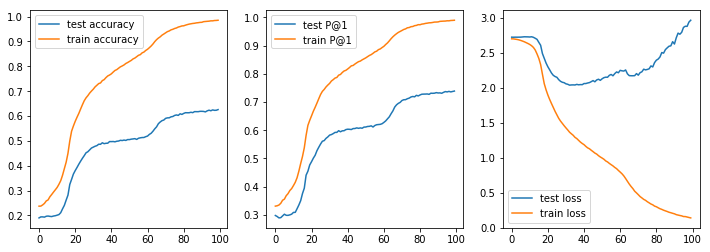

---------------------------------------------------------------------------------------------------- 

Hidden state size: 100
Train accuracy:0.988
Test accuracy:0.613
Train P@1:0.992
Test P@1:0.727
Train loss:0.128
Test loss:2.057


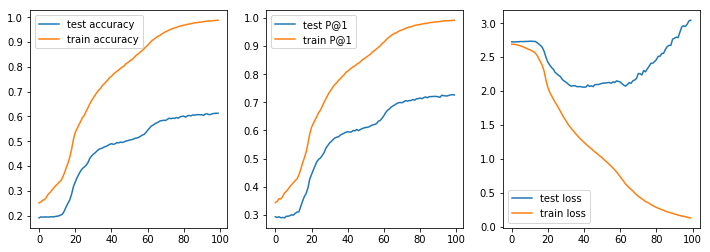

---------------------------------------------------------------------------------------------------- 

Hidden state size: 150
Train accuracy:0.989
Test accuracy:0.609
Train P@1:0.992
Test P@1:0.722
Train loss:0.129
Test loss:2.070


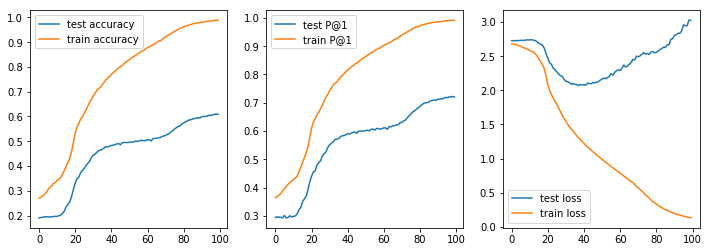

---------------------------------------------------------------------------------------------------- 



In [12]:
f = stats(imgBN_tst, imgBN_trn, epochs=100, params=[50, 100, 150])

In [14]:
arr = []
for i, num_hidden in enumerate([50, 100, 150]):
    arr.append([num_hidden,
               max(np.array(imgBN_tst[i])[:,0]), 
               max(np.array(imgBN_trn[i])[:,0]), 
               max(np.array(imgBN_tst[i])[:,1]), 
               max(np.array(imgBN_trn[i])[:,1]), 
               min(np.array(imgBN_tst[i])[:,2]), 
               min(np.array(imgBN_trn[i])[:,2])])
print(tabulate(arr, headers=['Hidden Dim', 'Test Accuracy', 'Train Accuracy', 'Test P@1', 'Train P@1', 'Test Loss',  'Train Loss'], tablefmt="fancy_grid"))

╒══════════════╤═════════════════╤══════════════════╤════════════╤═════════════╤═════════════╤══════════════╕
│   Hidden Dim │   Test Accuracy │   Train Accuracy │   Test P@1 │   Train P@1 │   Test Loss │   Train Loss │
╞══════════════╪═════════════════╪══════════════════╪════════════╪═════════════╪═════════════╪══════════════╡
│           50 │        0.625993 │         0.985505 │   0.739007 │    0.990185 │     2.03925 │     0.14481  │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          100 │        0.612795 │         0.988249 │   0.727037 │    0.991667 │     2.05701 │     0.128149 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          150 │        0.609444 │         0.988737 │   0.722121 │    0.9917   │     2.06982 │     0.129307 │
╘══════════════╧═════════════════╧══════════════════╧════════════╧═════════════╧═════════════╧══════════════╛


## Image and text BN 

Adding Batch Normalzation over both the image and text models

In [15]:
BN_tst, BN_trn = [], []
num_hiddens=[50, 100, 150]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'BN_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=testset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        bnorm=True,
        params_dir=params_dir
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)

    tst, trn = m.train(trainset, testset, epochs_num=100)
    BN_tst.append(tst)
    BN_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

Train accuracy:1.000
Test accuracy:0.713
Train P@1:1.000
Test P@1:0.805
Train loss loss:0.004
Test loss loss:1.775


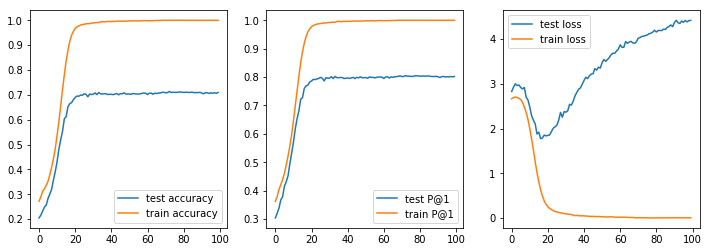

---------------------------------------------------------------------------------------------------- 

Train accuracy:1.000
Test accuracy:0.721
Train P@1:1.000
Test P@1:0.813
Train loss loss:0.004
Test loss loss:1.968


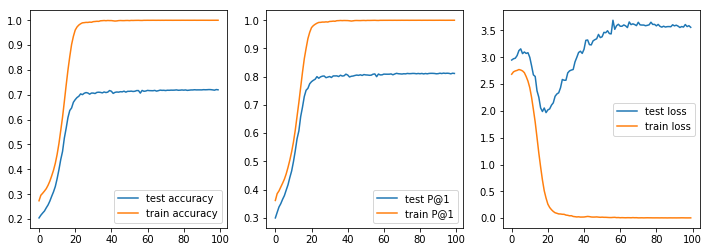

---------------------------------------------------------------------------------------------------- 

Train accuracy:1.000
Test accuracy:0.726
Train P@1:1.000
Test P@1:0.816
Train loss loss:0.003
Test loss loss:2.115


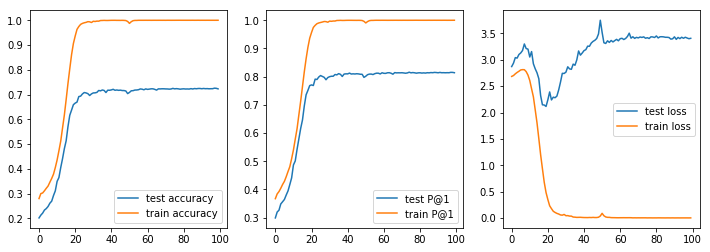

---------------------------------------------------------------------------------------------------- 



In [16]:
f = stats(BN_tst, BN_trn, epochs=100, params=[50, 100, 150])

In [17]:
arr = []
for i, num_hidden in enumerate([50, 100, 150]):
    arr.append([num_hidden,
               max(np.array(BN_tst[i])[:,0]), 
               max(np.array(BN_trn[i])[:,0]), 
               max(np.array(BN_tst[i])[:,1]), 
               max(np.array(BN_trn[i])[:,1]), 
               min(np.array(BN_tst[i])[:,2]), 
               min(np.array(BN_trn[i])[:,2])])
print(tabulate(arr, headers=['Hidden Dim', 'Test Accuracy', 'Train Accuracy', 'Test P@1', 'Train P@1', 'Test Loss',  'Train Loss'], tablefmt="fancy_grid"))

╒══════════════╤═════════════════╤══════════════════╤════════════╤═════════════╤═════════════╤══════════════╕
│   Hidden Dim │   Test Accuracy │   Train Accuracy │   Test P@1 │   Train P@1 │   Test Loss │   Train Loss │
╞══════════════╪═════════════════╪══════════════════╪════════════╪═════════════╪═════════════╪══════════════╡
│           50 │        0.713182 │         0.999815 │   0.805017 │    0.999966 │     1.77457 │   0.00416833 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          100 │        0.72096  │         0.999731 │   0.812593 │    0.999916 │     1.96806 │   0.00384872 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          150 │        0.725572 │         0.999764 │   0.815707 │    0.999899 │     2.11547 │   0.00347274 │
╘══════════════╧═════════════════╧══════════════════╧════════════╧═════════════╧═════════════╧══════════════╛
